# Introduction

##### Each protein sequence in the dataset consists of amino acids - each character is a representation of one amino acid

![20 amino acids that make up protein](https://i0.wp.com/www.compoundchem.com/wp-content/uploads/2014/09/20-Common-Amino-Acids.png?fit=2480%2C1754&ssl=1)


# Import Libraries

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random as random
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Hydropathy Calculation


In [13]:
hydropathy_index = {
    'A': 1.8,   # Alanine
    'C': 2.5,   # Cysteine
    'D': -3.5,  # Aspartic Acid
    'E': -3.5,  # Glutamic Acid
    'F': 2.8,   # Phenylalanine
    'G': -0.4,  # Glycine
    'H': -0.2,  # Histidine
    'I': 4.5,   # Isoleucine
    'K': -3.9,  # Lysine
    'L': 3.8,   # Leucine
    'M': 1.9,   # Methionine
    'N': -3.5,  # Asparagine
    'P': -1.6,  # Proline
    'Q': -3.5,  # Glutamine
    'R': -4.5,  # Arginine
    'S': -0.8,  # Serine
    'T': -0.7,  # Threonine
    'V': 4.2,   # Valine
    'W': -0.9,  # Tryptophan
    'Y': -1.3,  # Tyrosine
}


def hydropathy(protein_sequence, amino_acid_list):
    hydropathy = 0
    for amino_acid in protein_sequence:
        if amino_acid not in amino_acid_list:
            continue
        hydropathy += hydropathy_index[amino_acid]
    return hydropathy / len(protein_sequence)

# Net Charge Calculation


In [14]:
selected_pH = 7.0


pKa_values = {
        'K': 10.5,  # Lysine
        'R': 12.5,  # Arginine
        'H': 6.0,   # Histidine
        'D': 3.9,   # Aspartic acid
        'E': 4.2    # Glutamic acid
    }


def net_charge(protein_sequence, pH=selected_pH):
    
    charge = 0
    
    for amino_acid in protein_sequence:
        if amino_acid in pKa_values:
            if amino_acid in ['K', 'R', 'H']:  # Basic amino acids
                if pH < pKa_values[amino_acid]:
                    charge += 1  # Protonated form (positive charge)
            elif amino_acid in ['D', 'E']:  # Acidic amino acids
                if pH > pKa_values[amino_acid]:
                    charge -= 1  # Deprotonated form (negative charge)
    
    return charge


# Set up Feature Distribution


In [15]:
def plot_feature_distribution(data, feature, start=None, end=None):
    
    column_list = {1: "DNA-binding", 0: "non DNA-binding"}

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8)) 
    axes  = axes.flatten()

    for i, column in enumerate(column_list):
        used_data = data[data["Label"] == column][feature]
        axes[i].boxplot(used_data, patch_artist=True, 
                        boxprops=dict(facecolor='lightblue', 
                                      edgecolor='black'))
        axes[i].set_xlabel(feature)
        axes[i].set_title(column_list[column])
        axes[i].set_ylim(start, end)

    plt.subplots_adjust(wspace=0.25)
    plt.show()  

# Feature Scaling - Set up

In [16]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [17]:
def normalize(data):
    min_max_scaler = MinMaxScaler()
    normalized_data = min_max_scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, columns=data.columns)
    return normalized_df

    
def standardize(data):
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)
    standardized_df = pd.DataFrame(standardized_data, columns=data.columns)
    return standardized_df


def robust_scaling(data):
    scaler = RobustScaler()
    robust_scaled_data = scaler.fit_transform(data)
    robus_scaled_df = pd.DataFrame(robust_scaled_data, columns=data.columns)
    return robus_scaled_df

# Read data(.fasta file) and convert to .csv file

In [18]:
amino_acids_list = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 
                    'G', 'H', 'I', 'L', 'K', 'M', 'F', 
                    'P', 'S', 'T', 'W', 'Y', 'V']

##### Data Cleaning - Remove unnecessary amino acids

In [19]:
characters_to_remove = ['X', 'U', "O", "B"]


def remove_character(input_string, chars_to_remove):
    for char in chars_to_remove:
        input_string = input_string.replace(char, '')
    return input_string

##### Read .fasta file and convert to .csv file

In [20]:
def set_up_fasta_data(file_path, name):
    
    
    data = []
    records = SeqIO.parse(file_path, "fasta")

    for record in records:
        data.append([record.id, record.seq])
    
    data = pd.DataFrame(data, columns=["Label", "Sequence"])
    data['Label'] = data['Label'].apply(lambda x: x[-1])
    data['Length'] = data['Sequence'].apply(len)

    for amino_acid in amino_acids_list:
        data['Frequency_' + amino_acid] = data['Sequence'].apply(lambda x: 
                                            x.count(amino_acid) / len(x))
        
    data['Sequence'] = data['Sequence'].apply(lambda x: 
                                remove_character(x, characters_to_remove))
    
    # Create new column: Hydropathy
    data['Hydropathy'] = data['Sequence'].apply(lambda x: 
                        hydropathy(x, amino_acids_list))

    # Create new column: Net_charge
    data['Net_charge'] = data['Sequence'].apply(lambda x: net_charge(x))
    


    ########## ADDING PHYSIOCHEMICAL PROPERTIES ##########

    # Define empty lists to store the computed values for each feature column
    molecular_weights = []
    instability_indexes = []
    aromaticities = []
    flexibilities = []
    isoelectric_points = []
    sec_structure_fractions = []

    # Iterate through each protein sequence in the 'Sequence' column
    for seq in data['Sequence']:
        X = ProteinAnalysis(seq)
    
        # Append the computed values for each property to the respective list
        molecular_weights.append(X.molecular_weight())
        instability_indexes.append(X.instability_index())
        aromaticities.append(X.aromaticity())
        flexibilities.append(X.flexibility())  # Flexibility is a list
        isoelectric_points.append(X.isoelectric_point())
        sec_structure_fractions.append(X.secondary_structure_fraction())

    # Add these lists as new columns to your DataFrame
    data['Molecular Weight'] = molecular_weights
    data['Instability Index'] = instability_indexes
    data['Aromaticity'] = aromaticities
    data['Flexibility(Mean)'] = [sum(flex)/len(flex) if len(flex) > 0 
                                 else 0 for flex in flexibilities]
    data['Isoelectric Point'] = isoelectric_points
    data['Secondary Structure Fraction'] = [sum(fraction)/len(fraction) 
                                for fraction in sec_structure_fractions]
    
    
    
    ########## CONVERT TO CSV ##########
    
    data.to_csv(name, index=False)


    return data

##### Set up dataframe for train set and test set

In [21]:
# Read dataset(.fasta file) and convert to csv
#dna_train = set_up_fasta_data("Data/Train.fasta", "Data/DNA_Train.csv")
#dna_test = set_up_fasta_data('Data/Test.fasta', "Data/DNA_Test.csv")

##### Already convert and from now will use the csv file to read data (much faster)

In [22]:
train_data_path = os.path.join('..', 'Data', 'DNA_Train.csv')
test_data_path = os.path.join('..', 'Data', 'DNA_Test.csv')


# Define paths relative to the main folder
dna_train = pd.read_csv(train_data_path)
dna_test = pd.read_csv(test_data_path)


# Convert 'Label' to a categorical variable
dna_train['Label'] = pd.Categorical(dna_train['Label'])
dna_test['Label'] = pd.Categorical(dna_test['Label'])


# Remove missing values from the training data
dna_train = dna_train.dropna()
dna_test = dna_test.dropna()


# Ensure the labels are treated as binary
dna_train['Label'] = dna_train['Label'].cat.codes  # 0 for "0" and 1 for "1"
dna_test['Label'] = dna_test['Label'].cat.codes

# Feature Distribution

### Length

In [23]:
# plot_feature_distribution(dna_train, "Length", 0, 5000)

### Single Amino Acids Distribution

In [24]:
# for aa in amino_acids_list:
#     dna_train["Frequency_" + aa] = pd.to_numeric(dna_train["Frequency_" + aa], errors="coerce")
#     plot_feature_distribution(dna_train, "Frequency_" + aa, -0.01, 0.3)

### Compare Mean Frequency distribution between 2 classes

In [25]:
# Calculate median frequencies for both label 0 (non-binding) and label 1 (binding) for each amino acid
for aa in amino_acids_list:
    col_name = 'Frequency_' + aa
    dna_train[col_name] = pd.to_numeric(dna_train[col_name], errors='coerce')
    
df_training_0 = dna_train[dna_train["Label"] == 0]
df_training_1 = dna_train[dna_train["Label"] == 1]
mean_0 = [np.mean(df_training_0['Frequency_' + aa].dropna()) for aa in amino_acids_list]
mean_1 = [np.mean(df_training_1['Frequency_' + aa].dropna()) for aa in amino_acids_list]

# Create a new figure
plt.figure(figsize=(15, 8))

# Define the positions for the amino acids on the x-axis
x = np.arange(len(amino_acids_list))

# Bar width
bar_width = 0.35

# Plot bars for label 0 (non-binding) and label 1 (binding)
bars_0 = plt.bar(x - bar_width/2, mean_0, bar_width, label='Non-binding protein (0)', color='blue')
bars_1 = plt.bar(x + bar_width/2, mean_1, bar_width, label='DNA-binding protein (1)', color='orange')

# Set the x-axis ticks and labels (amino acids)
plt.xticks(x, amino_acids_list)

# Set the labels and title
plt.xlabel('Amino Acids', fontsize=12)
plt.ylabel('Median Frequency', fontsize=12)
plt.title('Comparison of Mean Amino Acid Distribution between Non-binding and DNA-binding Proteins', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

<Figure size 1500x800 with 0 Axes>

### Physiochemical Properties

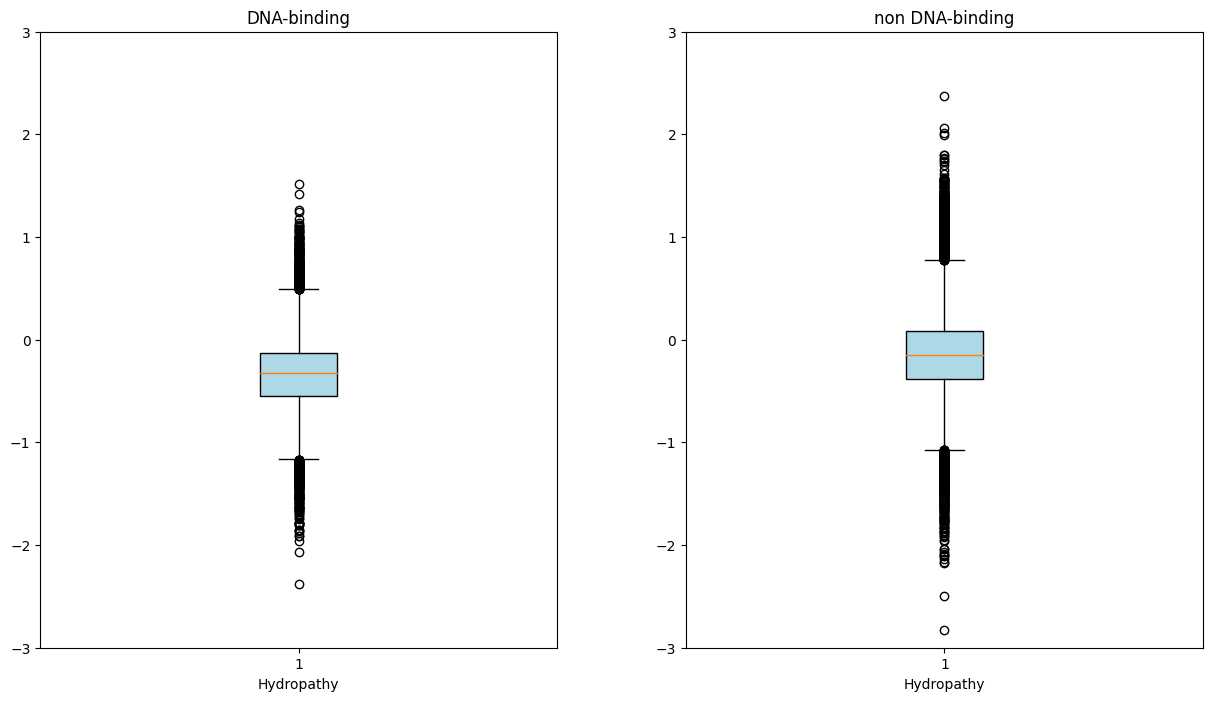

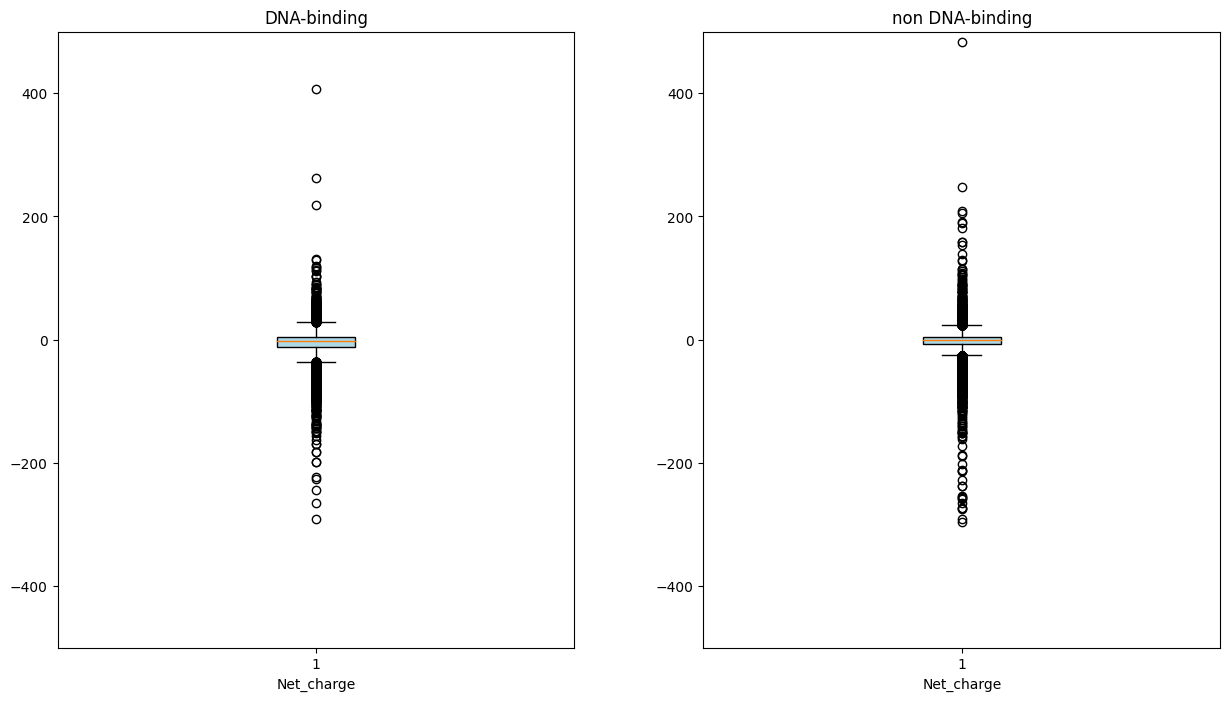

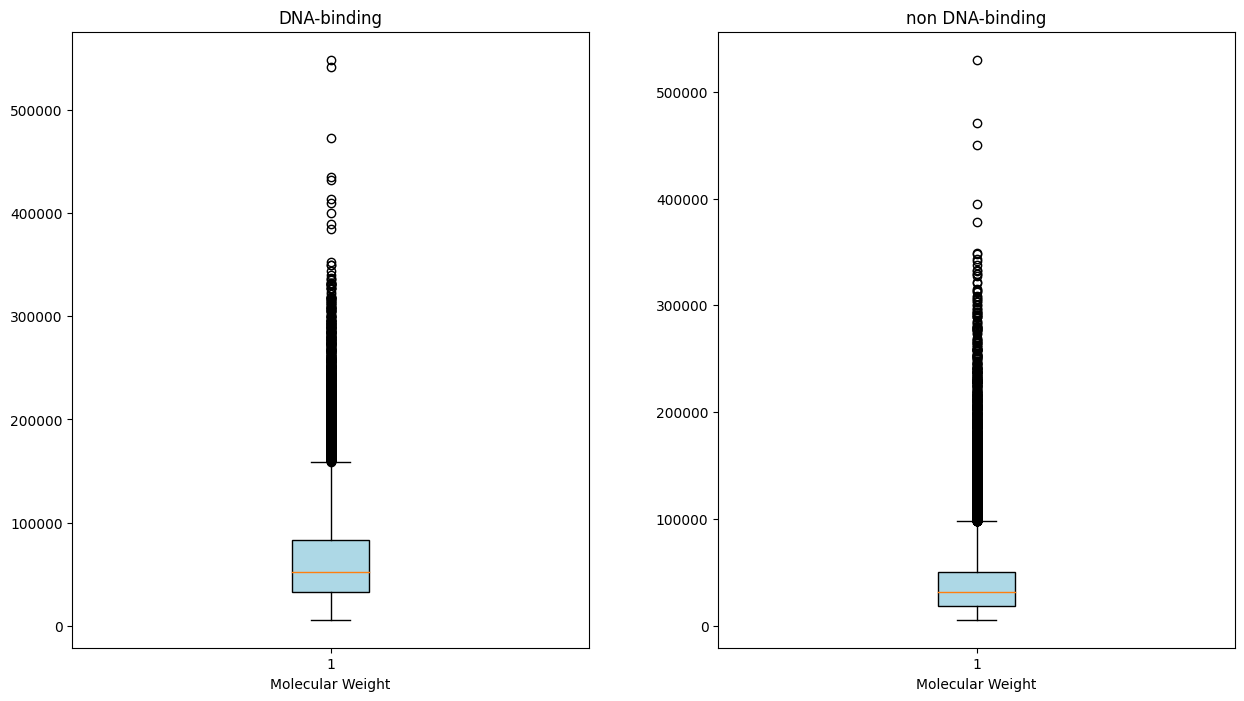

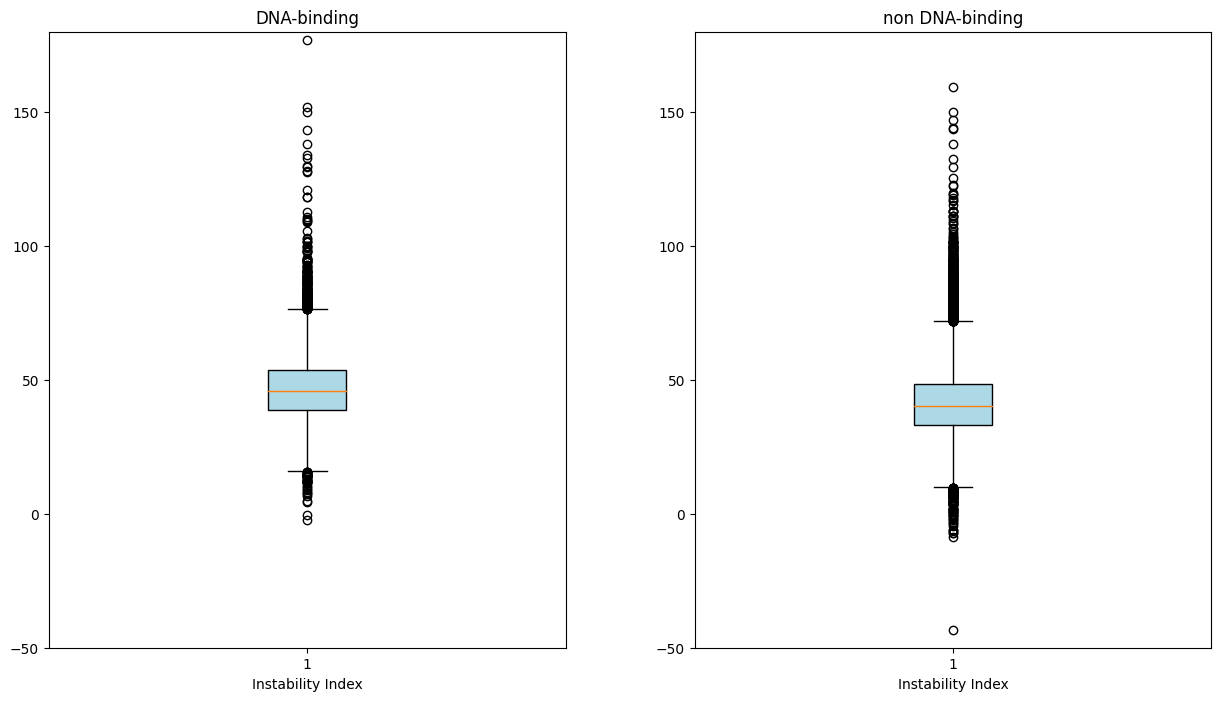

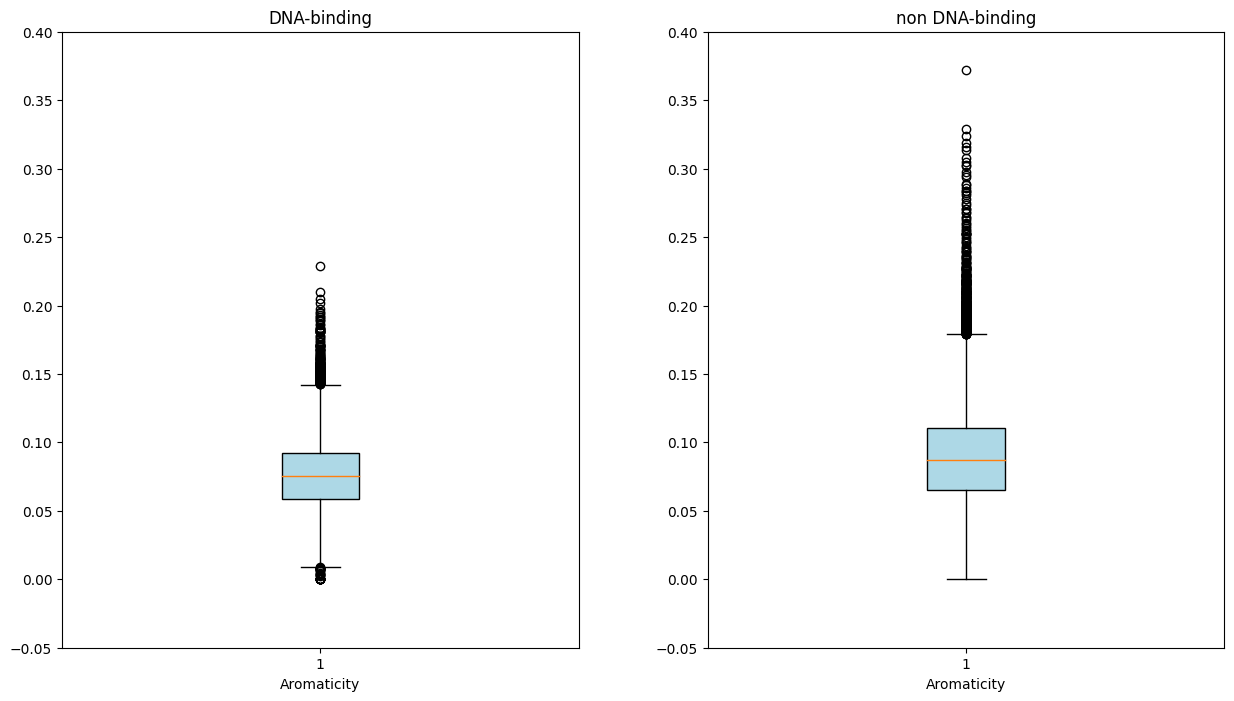

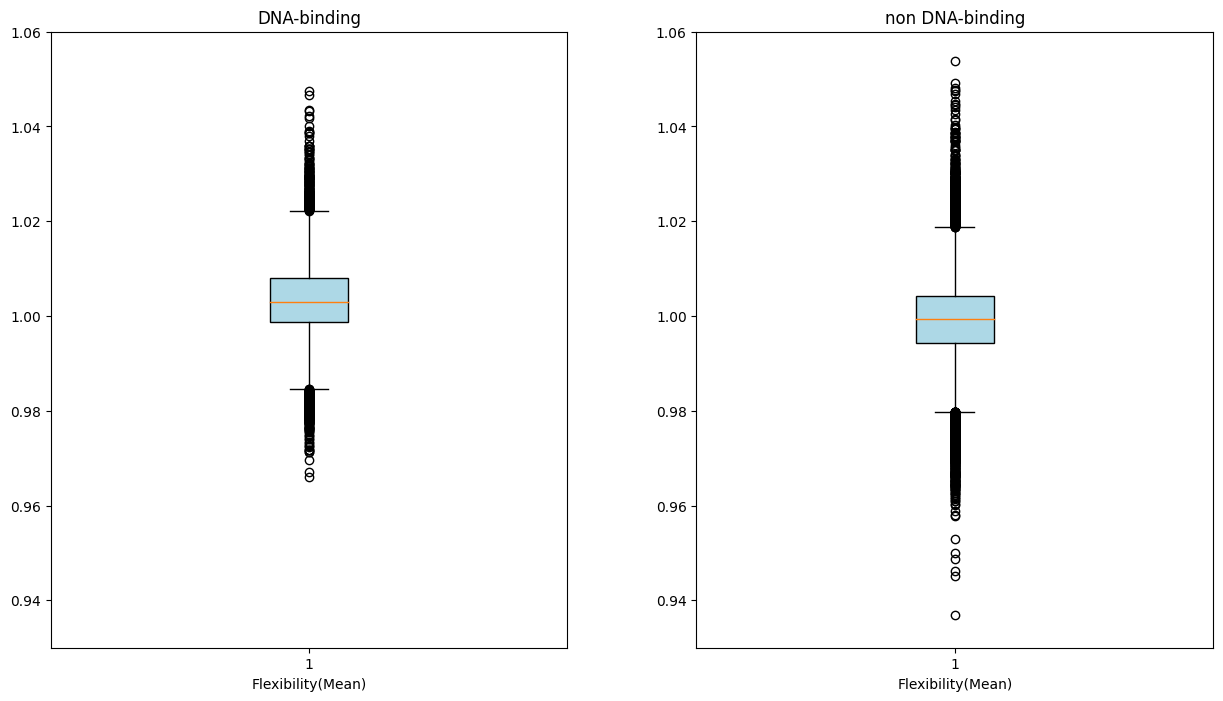

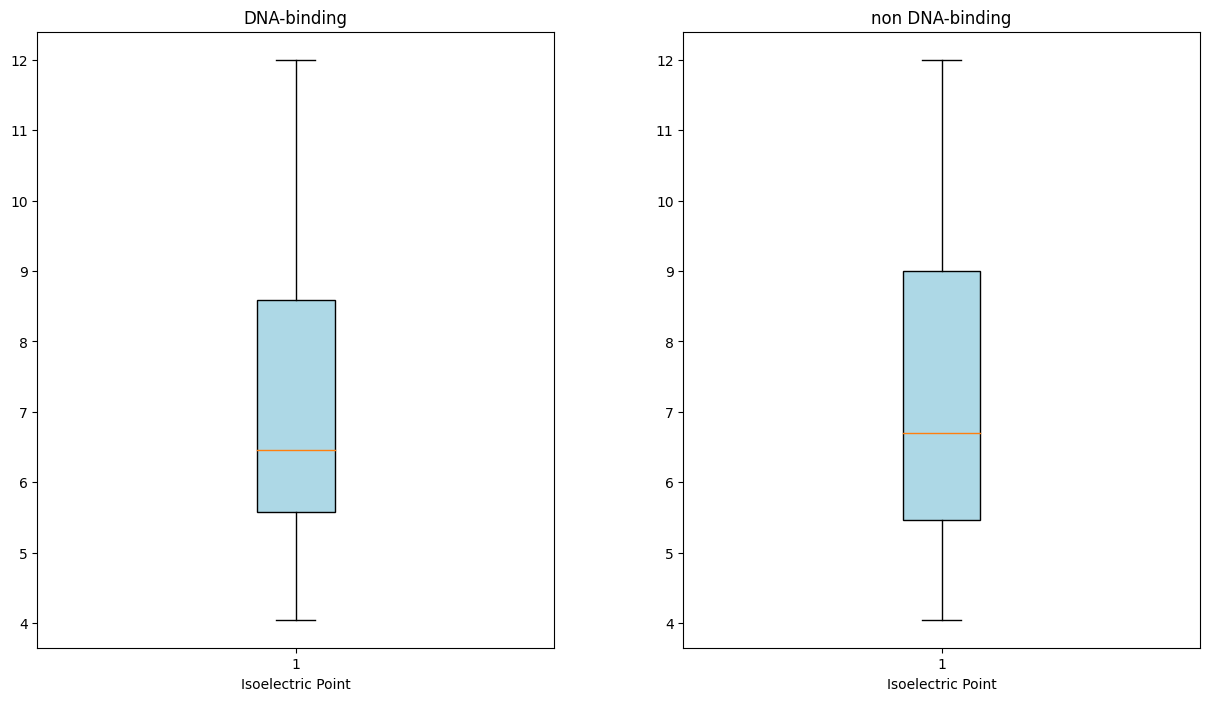

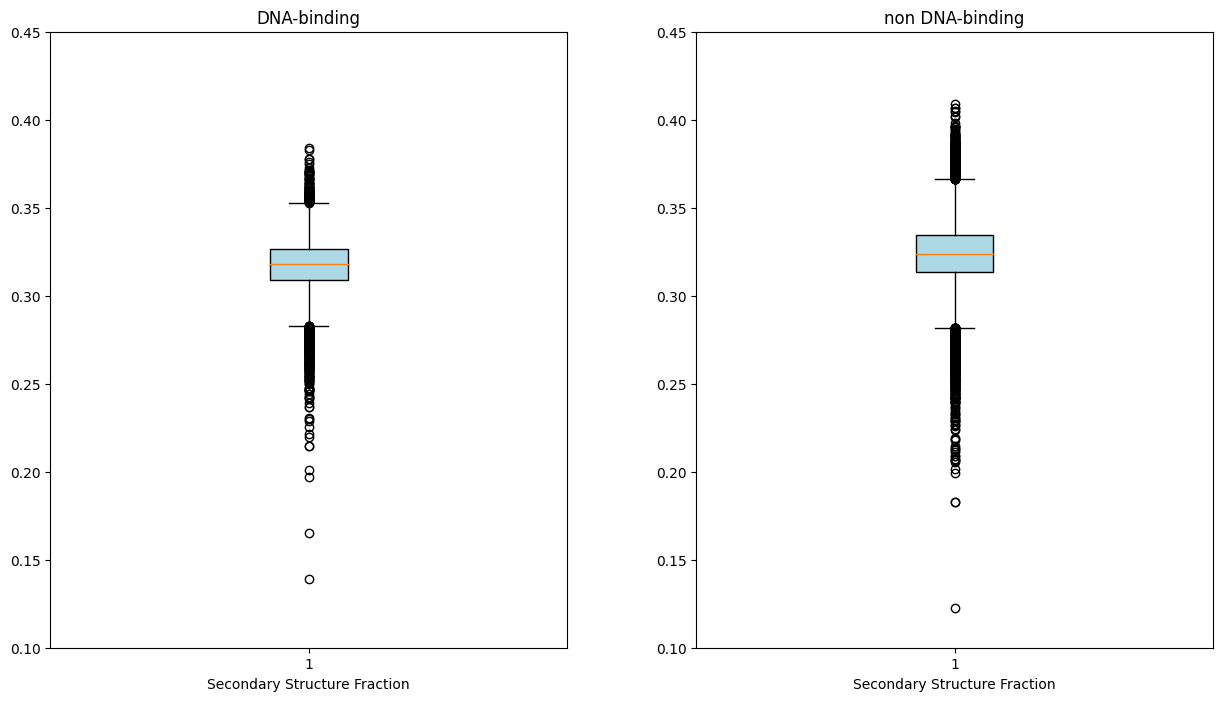

In [ ]:
plot_feature_distribution(dna_train, 'Hydropathy', -3, 3)

plot_feature_distribution(dna_train, 'Net_charge', -500, 500)

plot_feature_distribution(dna_train, 'Molecular Weight')

plot_feature_distribution(dna_train, 'Instability Index', -50, 180)

plot_feature_distribution(dna_train, 'Aromaticity', -0.05, 0.4)

plot_feature_distribution(dna_train, 'Flexibility(Mean)', 0.93, 1.06)

plot_feature_distribution(dna_train, 'Isoelectric Point')

plot_feature_distribution(dna_train, 'Secondary Structure Fraction', 0.1, 0.45)

# Set up features, trainX, trainY, testX, testY

### Column names

In [ ]:
columns = [ # 0
            'Length',
            
            # 1 - 20
            'Frequency_A', 'Frequency_R', 'Frequency_N', 'Frequency_D', 
            'Frequency_C', 'Frequency_E', 'Frequency_Q', 'Frequency_G', 
            'Frequency_H', 'Frequency_I', 'Frequency_L', 'Frequency_K', 
            'Frequency_M', 'Frequency_F', 'Frequency_P', 'Frequency_S', 
            'Frequency_T', 'Frequency_W', 'Frequency_Y', 'Frequency_V',
            
            # 21 - 22
            'Hydropathy', 
            'Net_charge',

            # 23 - 24
            'Molecular Weight',
            'Instability Index',
            
            # 25 - 26
            'Aromaticity',
            'Flexibility(Mean)',
            
            # 27 - 28
            'Isoelectric Point',
            'Secondary Structure Fraction' ]

### Choose features

In [ ]:
# columns_to_find = ['Frequency_R', 'Frequency_D', 
#                    'Frequency_E', 'Frequency_Q', 
#                    'Frequency_H', 'Frequency_I', 'Frequency_L', 
#                    'Frequency_F', 'Frequency_P', 'Frequency_S', 
#                    'Frequency_Y', 'Frequency_V']

columns_to_find = columns[21:]

# feature_name = "Full Amino Acids Distribution"
feature_name = "Full Physiochemical Properties"
# feature_name = "Selected Amino Acids Distribution"
# feature_name = "Selected Physiochemical Properties"

indices = [dna_train.columns.get_loc(col) for col 
           in columns_to_find if col in dna_train.columns]

features = indices

### Create train_x, train_y, test_x, test_y

In [ ]:
train_x = dna_train.iloc[:, features]
test_x = dna_test.iloc[:, features]
train_y = dna_train.iloc[:, 0]
test_y = dna_test.iloc[:, 0]

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
train_x, train_y = smote.fit_resample(train_x, train_y)

train_y.value_counts(normalize=True)

Label
1    0.5
0    0.5
Name: proportion, dtype: float64

# Model


### Import libraries

In [ ]:
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load


### Save models

In [ ]:
def save_model(model, name):

    path = os.path.join('..', 'Saved Model', name + '_Physicochemical_Properties.joblib')

    # Saving the model
    dump(model, path)

    # Loading the model
    loaded_model = load(path)

### Performance metrics - Set up

##### Confusion matrix

In [ ]:
def sketch_confusion_matrix(test_set, predicted_set, name):
    
    conf_matrix = confusion_matrix(test_set, predicted_set)
    
    plt.figure(figsize=(15, 8))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non DNA-Binding', 'DNA-Binding'], 
            yticklabels=['Non DNA-Binding', 'DNA-Binding'])
    
    plt.title('Confusion Matrix of ' + name + " - " + feature_name)
    
    plt.xlabel('Predicted Label')
    
    plt.ylabel('True Label')
    
    plt.show()
    
    return conf_matrix

##### Performance metrics

In [ ]:

def get_performance_metrics(test, pred ,name):
    
    # Calculate metrics
    accuracy = accuracy_score(test, pred)
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    f1 = f1_score(test, pred)
    mcc = matthews_corrcoef(test, pred)
    
    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()

    # Calculate sensitivity and specificitY
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall(Sensitivity)": recall,
        "F1 Score": f1,
        "Specificity": specificity,
        "MCC": mcc
    }
    
    print("Evaluation Metrics of " + name + " - " + feature_name + ":")
    print()
    
    for key, value in metrics.items():
        print(f"{key}: {value}")
    
    print()
    print()
    print("Classification Report of " + name + " - " + feature_name + ":")
    print()
    print(classification_report(test, pred))
    
    return metrics


##### AUC - ROC

In [ ]:
def plot_roc_curve(y_test, y_probs, name):
    
    # Step 5: Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Step 6: Plot ROC curve
    plt.figure(figsize=(15, 8))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC of '+ name + " - " + feature_name)
    plt.legend(loc="lower right")
    plt.show()

##### AUC - PR

In [ ]:
def plot_auc_pr(y_test, y_probs, name):
    # Step 1: Compute Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    
    # Step 2: Compute AUC-PR
    auc_pr = auc(recall, precision)
    
    # Step 3: Plot the Precision-Recall curve
    plt.figure(figsize=(15, 8))
    plt.plot(recall, precision, color='b', lw=2, label=f'PR curve (AUC = {auc_pr:.2f})')
    plt.xlabel('Sensitivity')
    plt.ylabel('Precision')
    plt.title('PR of ' + name + " - " + feature_name)
    plt.legend(loc="lower left")
    plt.show()

### LOGISTIC REGRESSION

Optimization terminated successfully.
         Current function value: 0.608534
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                70856
Model:                          Logit   Df Residuals:                    70847
Method:                           MLE   Df Model:                            8
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                  0.1221
Time:                        00:16:31   Log-Likelihood:                -43118.
converged:                       True   LL-Null:                       -49114.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            7.1310      3.518      2.027      0.043

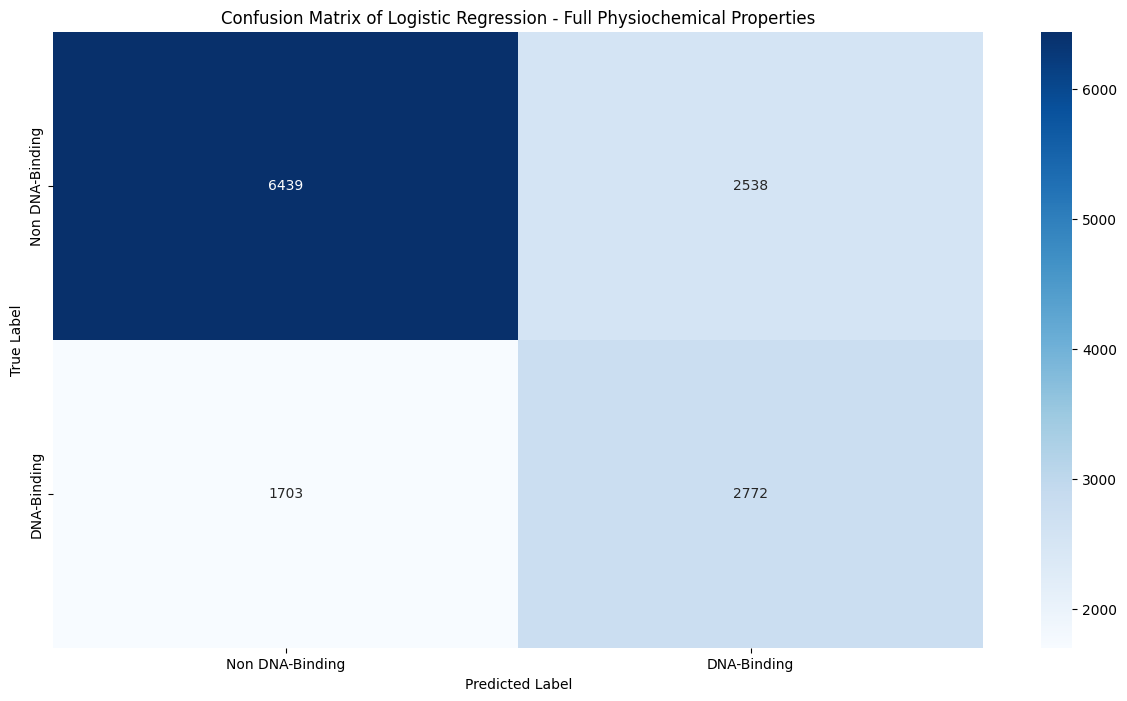


Evaluation Metrics of LOGISTIC REGRESSION - Full Physiochemical Properties:

Accuracy: 0.6847308950341957
Precision: 0.5220338983050847
Recall(Sensitivity): 0.6194413407821229
F1 Score: 0.5665815022994379
Specificity: 0.7172774869109948
MCC: 0.3245762389847214


Classification Report of LOGISTIC REGRESSION - Full Physiochemical Properties:

              precision    recall  f1-score   support

           0       0.79      0.72      0.75      8977
           1       0.52      0.62      0.57      4475

    accuracy                           0.68     13452
   macro avg       0.66      0.67      0.66     13452
weighted avg       0.70      0.68      0.69     13452



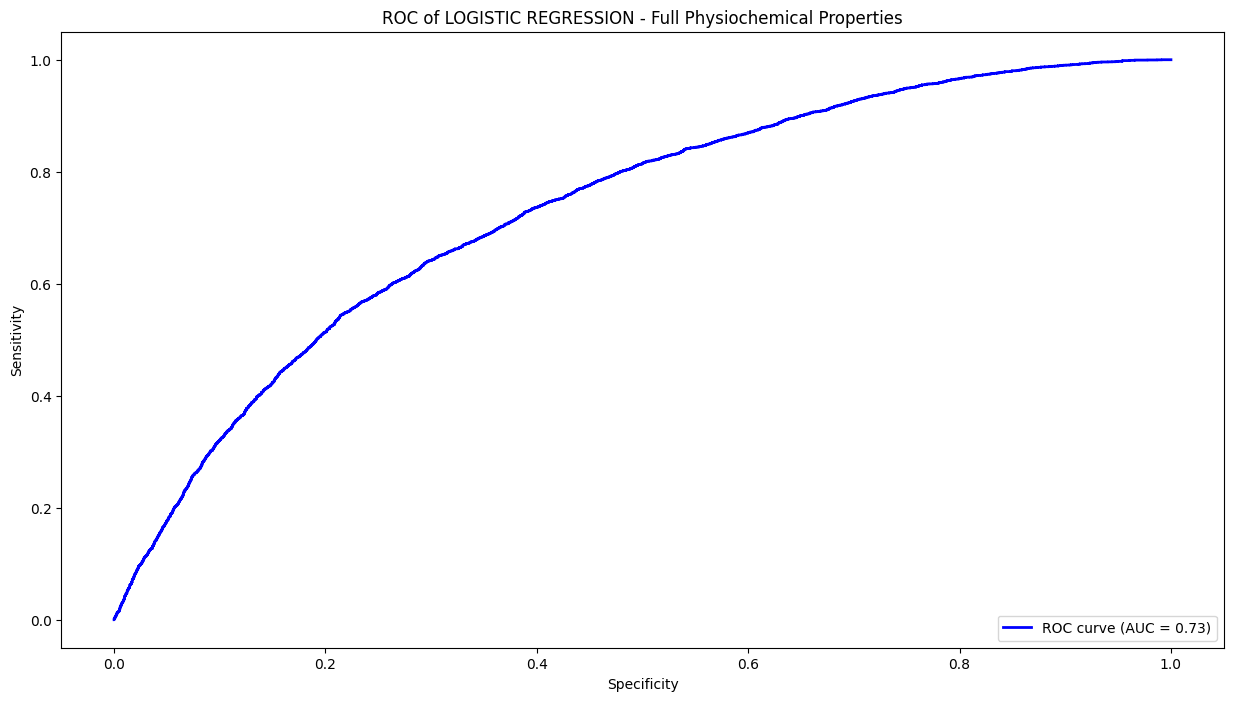

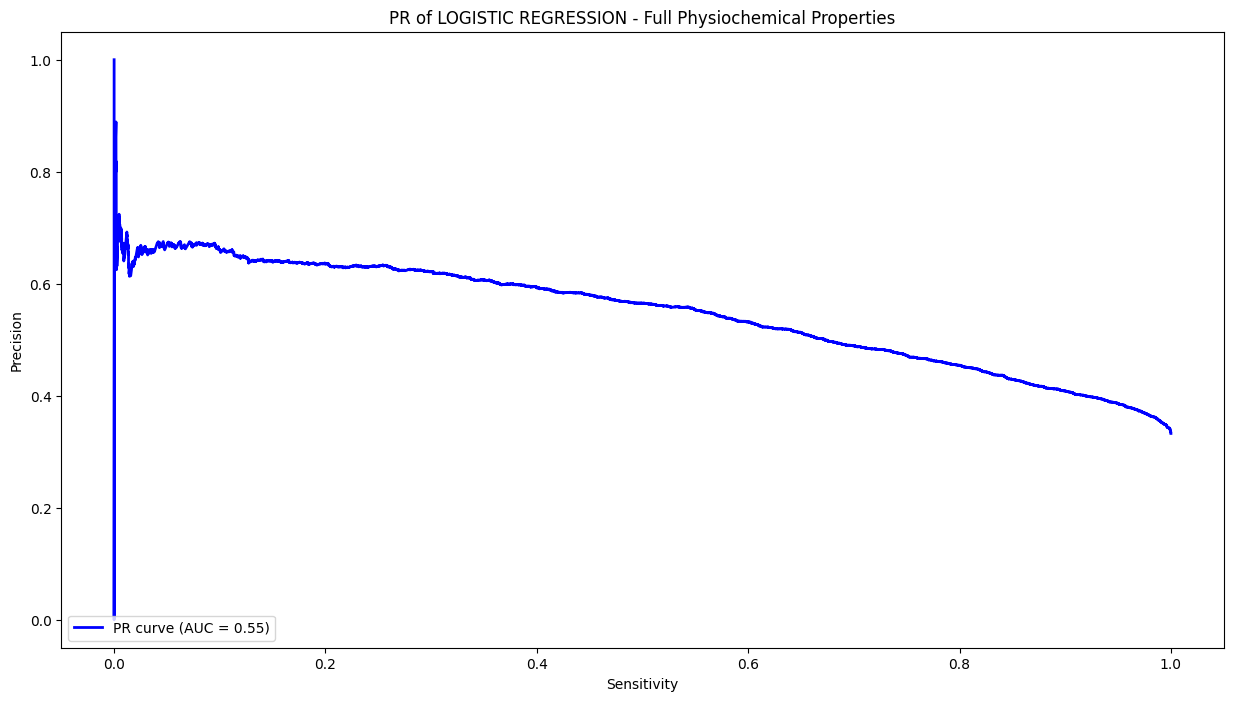

In [ ]:

# Add a constant (intercept) to the model
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)


# Fit logistic regression model
logit_model = sm.Logit(train_y, train_x)
result = logit_model.fit()


# Save model
# save_model(result, "LR")


# Print summary (which includes p-values)
print(result.summary())


# Predict probabilities and classes on the test set
predicted_probs = result.predict(test_x)
predicted_classes = np.where(predicted_probs >= 0.5, 1, 0)


# Confusion matrix
conf_matrix = sketch_confusion_matrix(test_y, predicted_classes, 
                        "Logistic Regression")
 

# Performance metrics
print()
get_performance_metrics(test_y, predicted_classes, "LOGISTIC REGRESSION")
plot_roc_curve(test_y, predicted_probs, "LOGISTIC REGRESSION")
plot_auc_pr(test_y, predicted_probs, "LOGISTIC REGRESSION")


### K NEAREST NEIGHBOURS

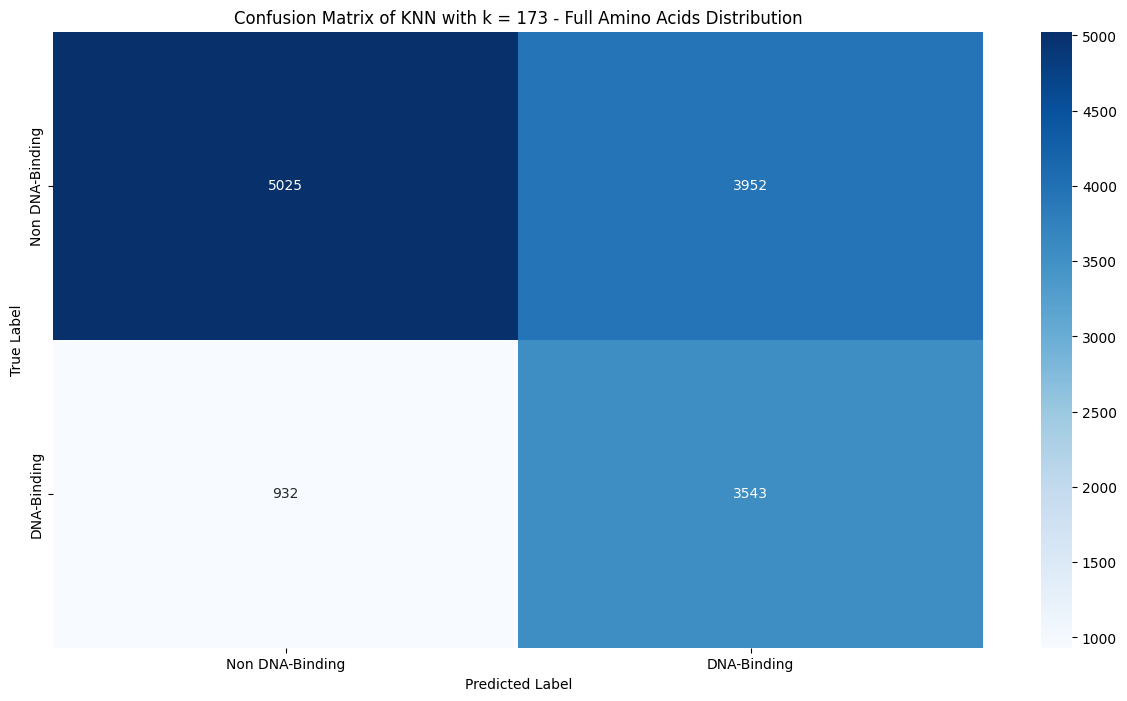

Evaluation Metrics of KNN with k = 173 - Full Amino Acids Distribution:

Accuracy: 0.6369313113291704
Precision: 0.47271514342895266
Recall(Sensitivity): 0.791731843575419
F1 Score: 0.5919799498746867
Specificity: 0.559763840926813
MCC: 0.33341298606037223


Classification Report of KNN with k = 173 - Full Amino Acids Distribution:

              precision    recall  f1-score   support

           0       0.84      0.56      0.67      8977
           1       0.47      0.79      0.59      4475

    accuracy                           0.64     13452
   macro avg       0.66      0.68      0.63     13452
weighted avg       0.72      0.64      0.65     13452



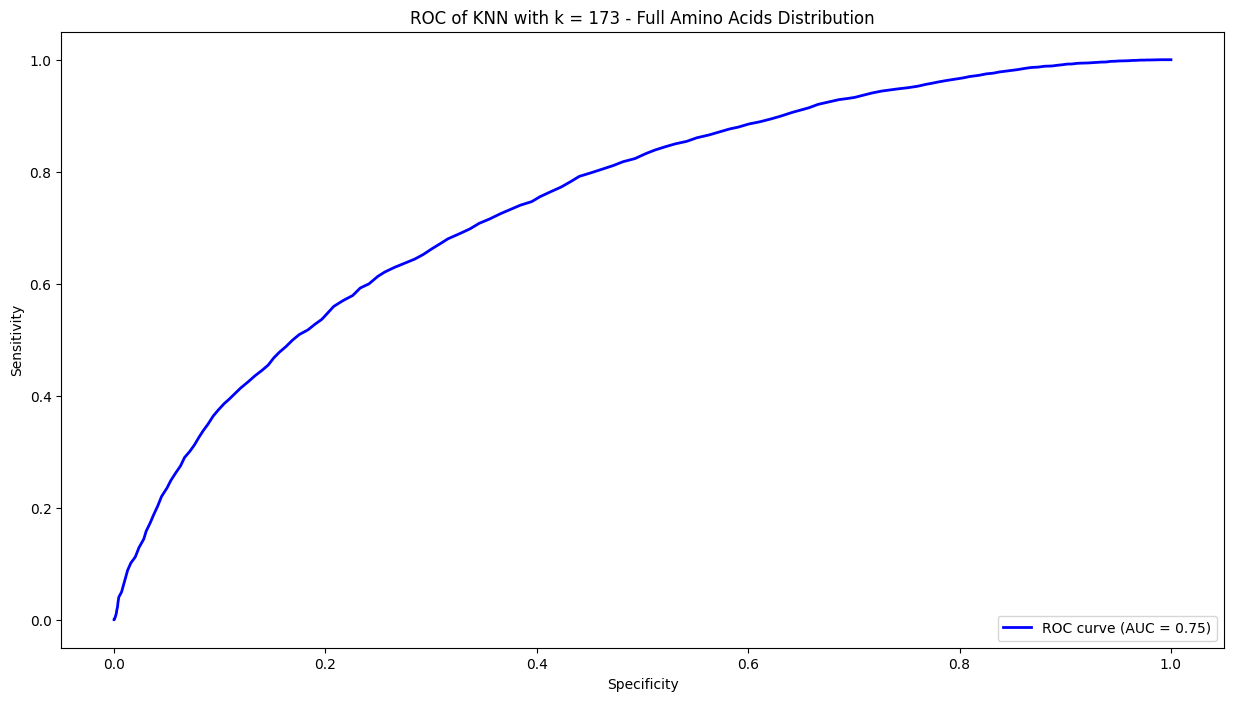

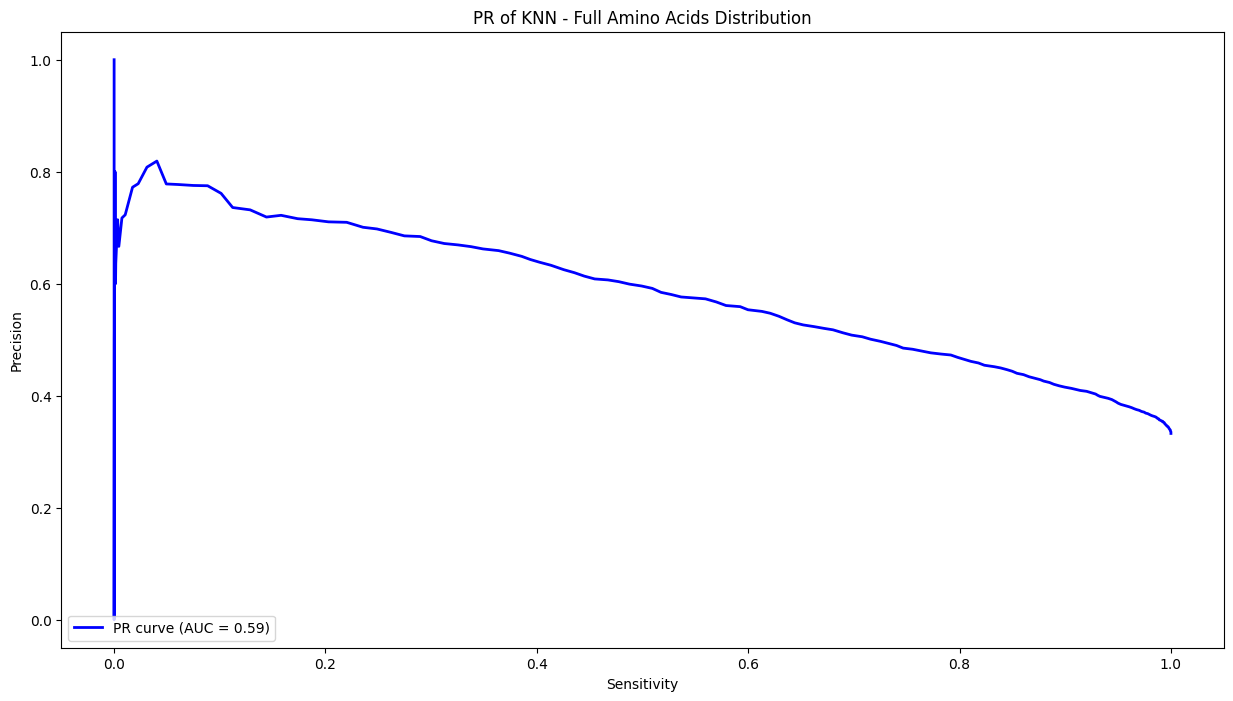

In [ ]:
# Feature scaling
train_x_scaled = standardize(train_x)
test_x_scaled = standardize(test_x)


# Choose k value

# mcc_list = []

# for k in range(1, 231, 2):
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(train_x_scaled, train_y)
#     knn_pred = knn.predict(test_x_scaled)
#     mcc_list.append([k, matthews_corrcoef(test_y, knn_pred)])

# print(max(mcc_list, key=lambda x: x[1]))


# Create the k-NN classifier with value k
k = 173
knn = KNeighborsClassifier(n_neighbors=k)


# Fit the model on the training data
knn.fit(train_x_scaled, train_y)


# Save model
# save_model(knn, "KNN")


# Make predictions on the test data
knn_pred = knn.predict(test_x_scaled)
knn_scores = knn.predict_proba(test_x_scaled)[:,1]


# Confusion matrix
conf_matrix = sketch_confusion_matrix(test_y, knn_pred, "KNN with k = " + str(k))


# Performance metrics
get_performance_metrics(test_y, knn_pred, "KNN with k = " + str(k))
plot_roc_curve(test_y, knn_scores, "KNN with k = " + str(k))
plot_auc_pr(test_y, knn_scores, "KNN")

### DECISION TREE

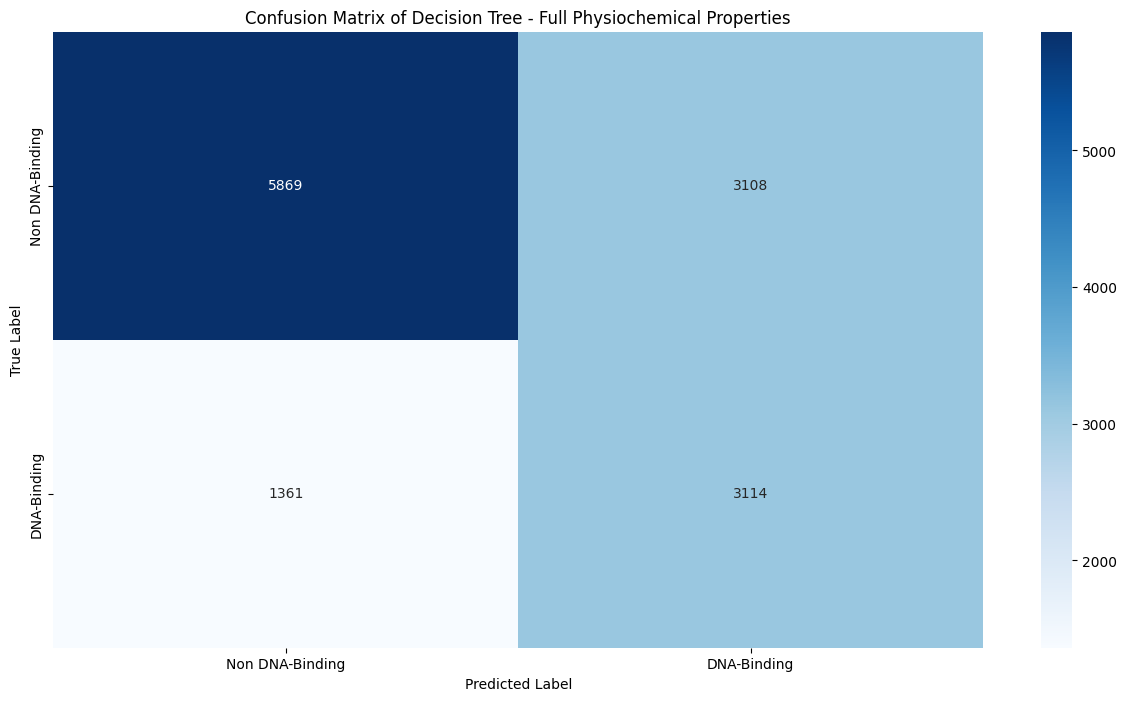

Evaluation Metrics of DECISION TREE - Full Physiochemical Properties:

Accuracy: 0.6677817424918228
Precision: 0.5004821600771456
Recall(Sensitivity): 0.6958659217877095
F1 Score: 0.5822193138263064
Specificity: 0.6537818870446697
MCC: 0.33041426686945874


Classification Report of DECISION TREE - Full Physiochemical Properties:

              precision    recall  f1-score   support

           0       0.81      0.65      0.72      8977
           1       0.50      0.70      0.58      4475

    accuracy                           0.67     13452
   macro avg       0.66      0.67      0.65     13452
weighted avg       0.71      0.67      0.68     13452



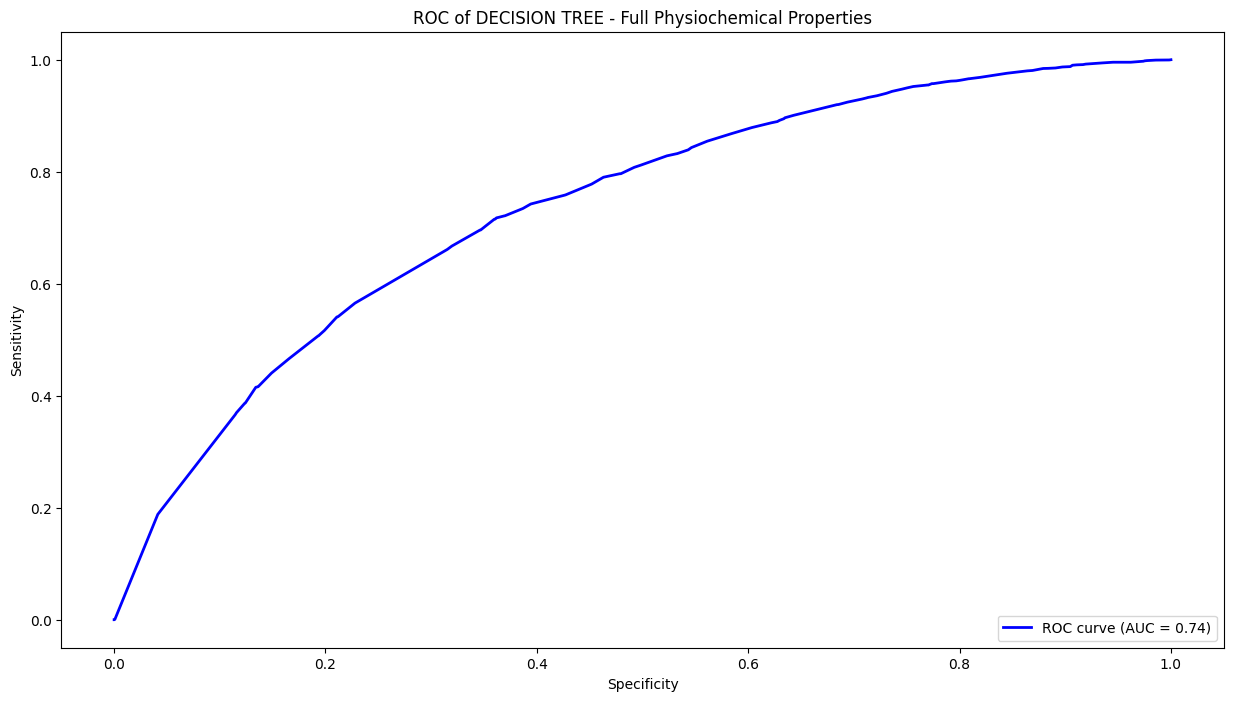

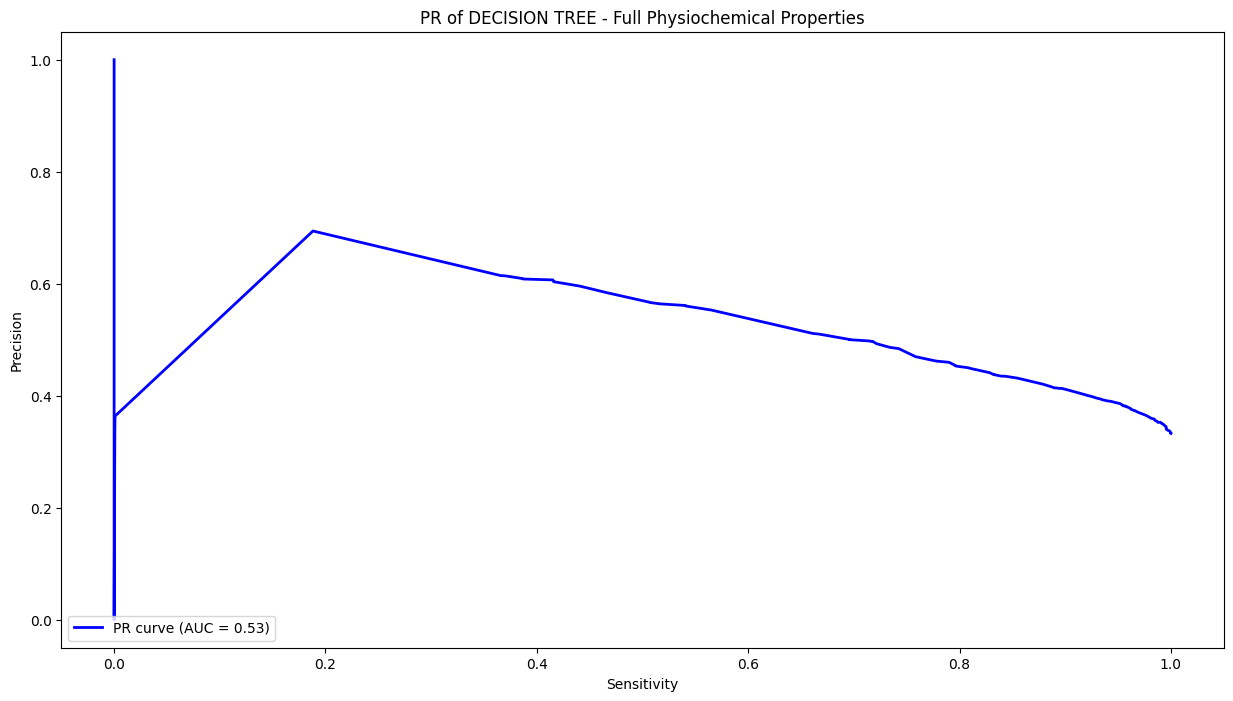

In [ ]:
# mcc_list = []

# for k in range(1, 101):
#     dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=k)
#     dt_model.fit(train_x_scaled, train_y)
#     dt_pred = dt_model.predict(test_x_scaled)
#     mcc_list.append([k, matthews_corrcoef(test_y, dt_pred)])

# print(max(mcc_list, key=lambda x: x[1]))


# Initialize and fit Decision Tree
dt_model = DecisionTreeClassifier(criterion="gini", min_samples_split=2, max_depth=7)
dt_model.fit(train_x, train_y)


# Save model
# save_model(dt_model, "DT")


# Predict
dt_pred = dt_model.predict(test_x)
dt_scores = dt_model.predict_proba(test_x)[:,1]


# Visualize the Decision Tree
# plt.figure(figsize=(20,10)) 
# plot_tree(dt_model, filled=True, feature_names=train_x.columns, 
#           class_names=["0", "1"], rounded=True, fontsize=14)
# plt.title("Decision Tree - Physiochemical Properties")
# plt.show()


# Confusion matrix
conf_matrix = sketch_confusion_matrix(test_y, dt_pred, 
      "Decision Tree")


# Accuracy
get_performance_metrics(test_y, dt_pred, "DECISION TREE")
plot_roc_curve(test_y, dt_scores, "DECISION TREE")
plot_auc_pr(test_y, dt_scores, "DECISION TREE")

### NAIVE BAYES 

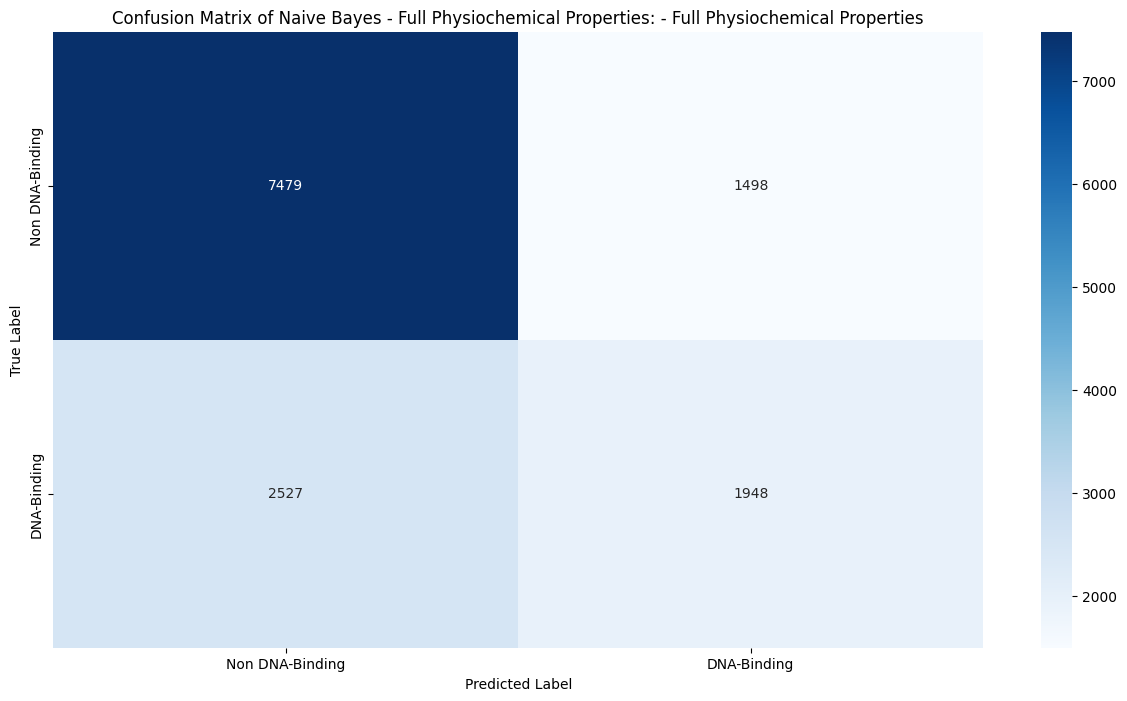

Evaluation Metrics of NAIVE BAYES - Full Physiochemical Properties:

Accuracy: 0.7007879869164436
Precision: 0.5652930934416716
Recall(Sensitivity): 0.4353072625698324
F1 Score: 0.49185708875142026
Specificity: 0.8331291077197281
MCC: 0.2897447692331665


Classification Report of NAIVE BAYES - Full Physiochemical Properties:

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      8977
           1       0.57      0.44      0.49      4475

    accuracy                           0.70     13452
   macro avg       0.66      0.63      0.64     13452
weighted avg       0.69      0.70      0.69     13452



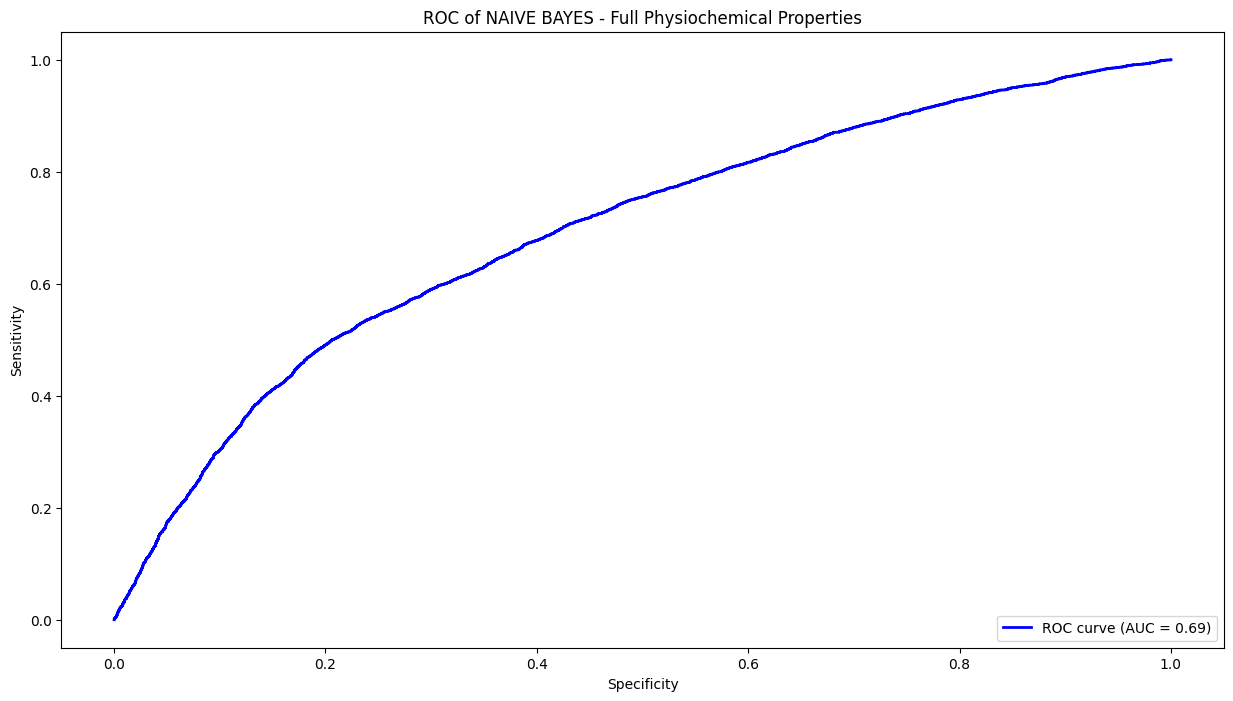

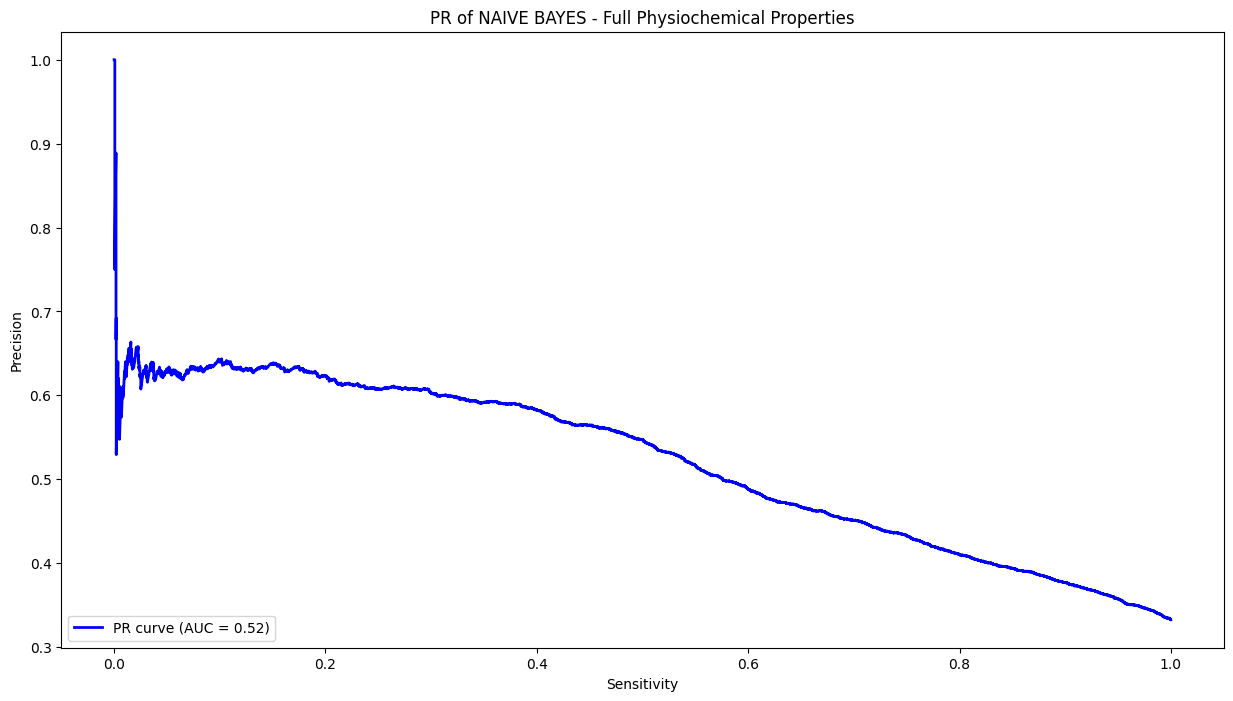

In [ ]:
# Initialize and fit Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_x, train_y)


# Save model
# save_model(nb_model, "NB")


# Predict
nb_pred = nb_model.predict(test_x)
nb_scores = nb_model.predict_proba(test_x)[:,1]


# Confusion matrix
conf_matrix = sketch_confusion_matrix(test_y, nb_pred, 
      "Naive Bayes - " + feature_name + ":")


# Performance metrics
get_performance_metrics(test_y, nb_pred, "NAIVE BAYES")
plot_roc_curve(test_y, nb_scores, "NAIVE BAYES")
plot_auc_pr(test_y, nb_scores, "NAIVE BAYES")

### RANDOM FOREST 

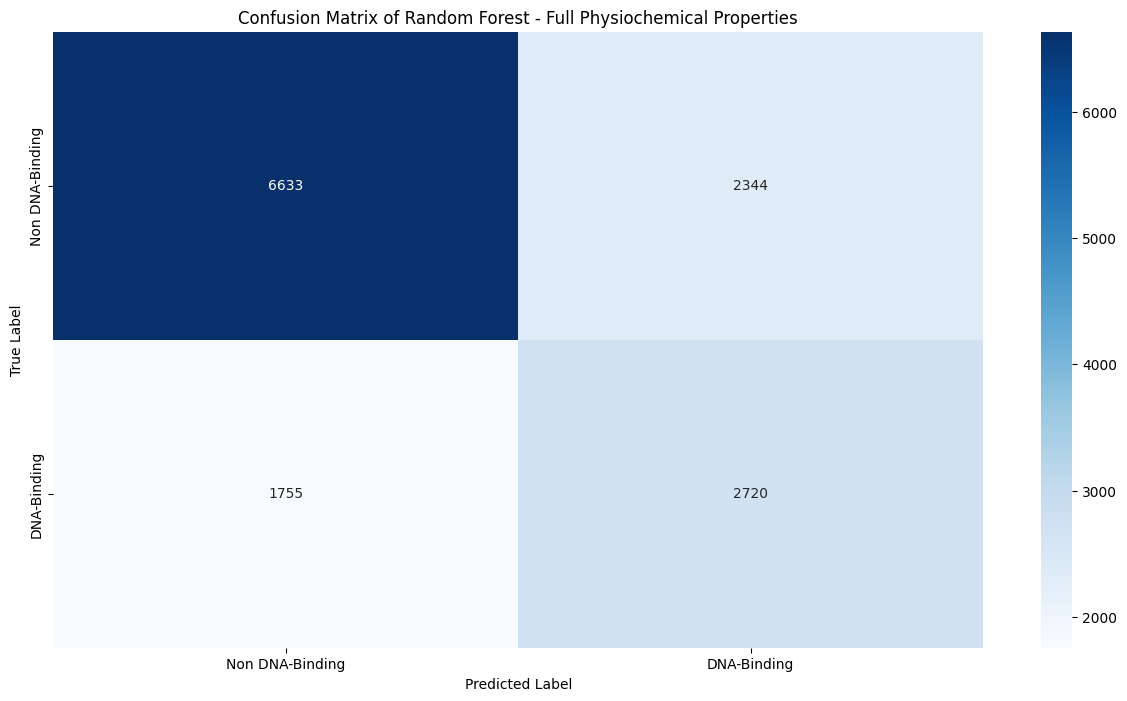

Evaluation Metrics of RANDOM FOREST - Full Physiochemical Properties:

Accuracy: 0.6952869461790069
Precision: 0.5371248025276462
Recall(Sensitivity): 0.6078212290502794
F1 Score: 0.5702903868330014
Specificity: 0.7388882700233931
MCC: 0.3371722418396058


Classification Report of RANDOM FOREST - Full Physiochemical Properties:

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      8977
           1       0.54      0.61      0.57      4475

    accuracy                           0.70     13452
   macro avg       0.66      0.67      0.67     13452
weighted avg       0.71      0.70      0.70     13452



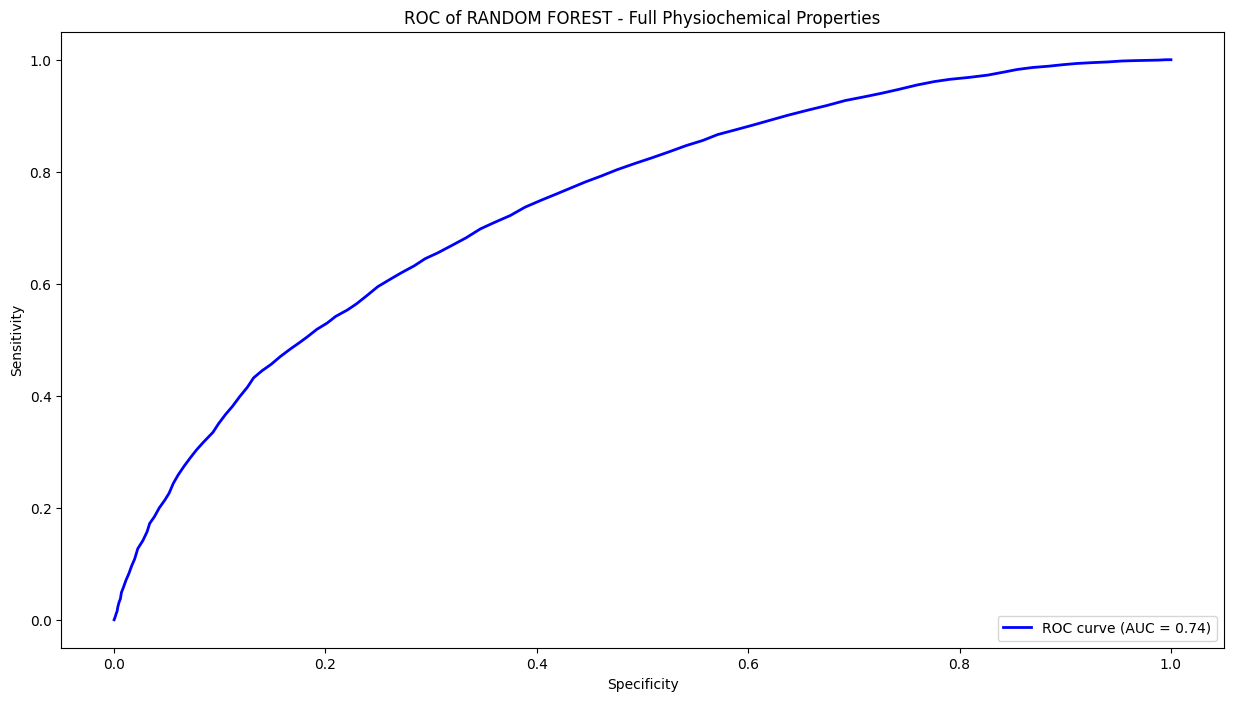

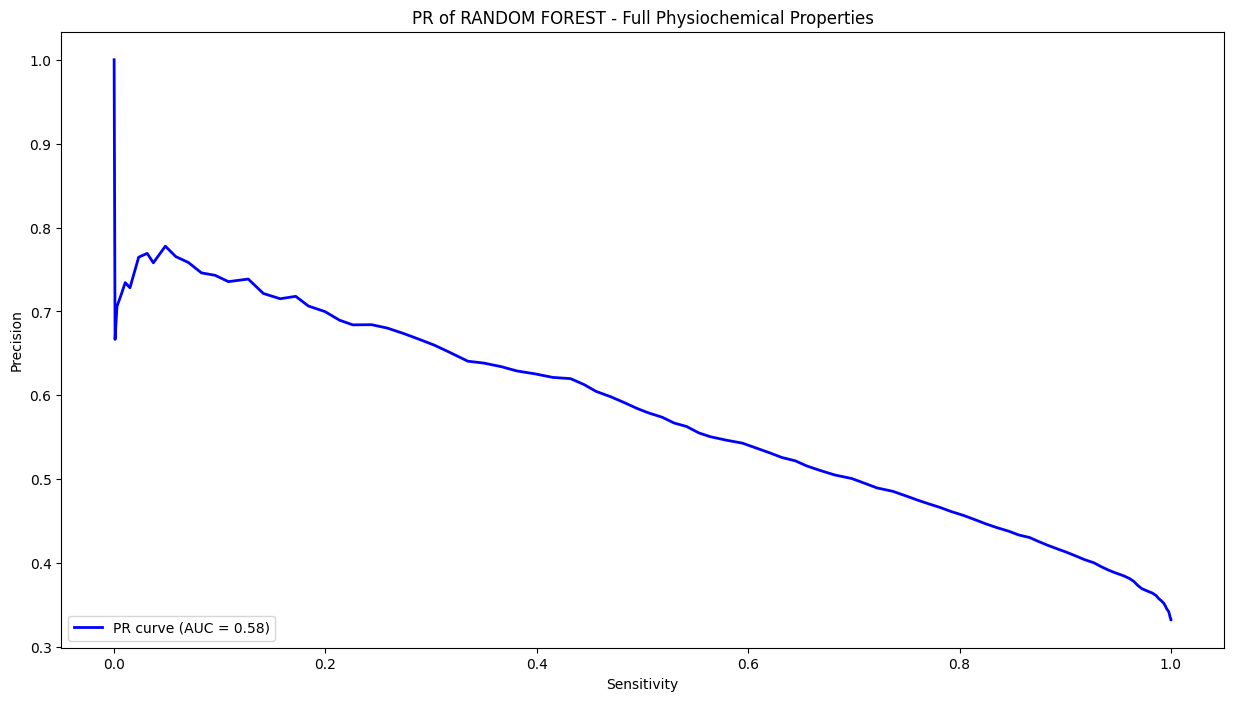

In [ ]:
# Initialize and fit Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_x, train_y)


# Save model
# save_model(rf_model, "RF")


# Performance metrics
rf_pred = rf_model.predict(test_x)
rf_scores = rf_model.predict_proba(test_x)[:,1]


# Confusion matrix
conf_matrix = sketch_confusion_matrix(test_y, rf_pred, 
      "Random Forest")


# Performance metrics
get_performance_metrics(test_y, rf_pred, "RANDOM FOREST")
plot_roc_curve(test_y, rf_scores, "RANDOM FOREST")
plot_auc_pr(test_y, rf_scores, "RANDOM FOREST")

### SUPPORT VECTOR MACHINE

In [ ]:
# # Feature scaling
# train_x_scaled = standardize(train_x)
# test_x_scaled = standardize(test_x)


# # Initialize and fit SVM
# svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
# svm_model.fit(train_x_scaled, train_y)


# # Save model
# # save_model(svm_model, 'SVM')


# # Predict
# svm_pred = svm_model.predict(test_x_scaled)
# svm_scores = svm_model.predict_proba(test_x_scaled)[:,1]


# # Confusion matrix
# conf_matrix = sketch_confusion_matrix(test_y, svm_pred, 
#       "Support Vector Machine")


# # Performance metrics
# print(get_performance_metrics(test_y, svm_pred, "SUPPORT VECTOR MACHINE"))
# plot_roc_curve(test_y, svm_scores, "SUPPORT VECTOR MACHINE") 
# plot_auc_pr(test_y, svm_scores, "SUPPORT VECTOR MACHINE")